# Using cholesky to create correlated weights

 \begin{align*}
 G_0 & = \sum_{k=1}^\infty \beta_k \delta_{\phi_k} \\
 G_j &= \sum_{k=1}^\infty \pi_{jk} \delta_{\phi_k} \\
 \phi_k & \sim \text{Dirichlet} \\

 \end{align*}

 The model above is the original HDP model. What we would then like to do is to incorporate the correlation of the weights to say that 

\begin{equation}
\text{cov} ( \log \pi_i, \log \pi_j) = \exp(-\xi||s_i - s_j||) = (H_n(\xi))_{ij} 
\end{equation}

where $s_i$ is the location of cell $i$ and $\pi_i$ is the weights for cell $i$ over the different topics. In general we would like 
\begin{equation}
\log \Pi \sim N_n(\mu_n, H_n(\xi))
\end{equation}
We only look at it in chunks at a time. So we will have full filled the correlation with-in the chunk. 

Problems:

- What is the distribution of the new correlated weights we are creating?

In [1]:
import scanpy as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data
adata_sub=sc.read_h5ad("HubID/Gensim_revised/objects/LH_VMSC02001_sub.h5ad")

with open('HubID/Gensim_revised/objects/LH_VMSC02001_sub_dictionary.pkl', 'rb') as ff:
    dictionary = pickle.load(ff)

with open('HubID/Gensim_revised/objects/LH_VMSC02001_sub_BoW_corpus.pkl', 'rb') as f2:
    BoW_corpus = pickle.load(f2)

spatial=adata_sub.obsm['spatial']

## Running the original hdp model

In [3]:
from hdpmodel import HdpModel
T=100
K =100
hdp0 = HdpModel(BoW_corpus, dictionary, T = T, K = K, random_state=2)
with open('LHsample_base.pkl', 'wb') as file:
    pickle.dump(hdp0, file)

In [4]:
# recovering the weights for the different topics
result_dist0=hdp0[BoW_corpus]

# save the HDP clusters to the object
prop0 = np.empty((len(BoW_corpus),T), float)#pd.DataFrame([])
for ii in range(len(BoW_corpus)):
    #dic={}
    rr=np.zeros(T)
    result=np.array(result_dist0[ii])
    rr[result[:,0].astype(int)]=result[:,1]
    rr=np.reshape(rr,(1,T)) 
    prop0[ii,:]=rr

# taking out topics with positive probability
#pos = prop0[:,np.where(np.sum(prop0, axis = 0) > 0)].squeeze()
pos = prop0

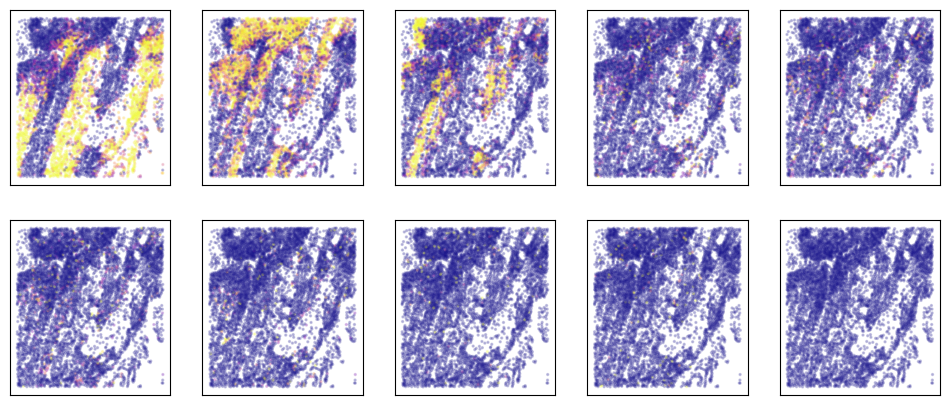

In [5]:
max_val = np.percentile(pos, 99, 0)
min_val = np.percentile(pos, 1, 0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = pos[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])

# Incoorporating spatial information for the weights

In [6]:
def squared_dist(X, Z):
    
    X2 = (X**2).sum(1, keepdims=True)
    Z2 = (Z**2).sum(1, keepdims=True)
    XZ = X @ Z.T
    r2 = np.sqrt(X2 - 2 * XZ + Z2.T)
    return r2
# create distance matrix
cells = spatial.shape[0]
dist = squared_dist(spatial,spatial)

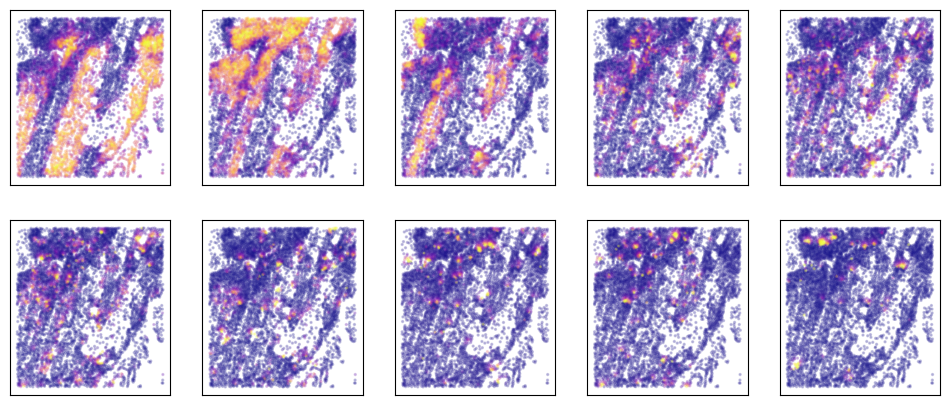

In [7]:
# add cholesky to weights 
# create covariance matrix
phi = 3/np.percentile(dist,0.5)
sigma = 1
cov = np.exp(-phi*dist)

L = np.linalg.cholesky(cov)

mat_s_chol = L @ pos

max_val = np.percentile(mat_s_chol, 99, 0)
min_val = np.percentile(mat_s_chol, 1, 0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])


## Own hdp function

In [ ]:
from HubID.GaussianPrior.hdpmodelchunk import HdpModel_spatial
T=50
K = 50
hdp_s = HdpModel_spatial(BoW_corpus, dictionary, dist = cov, passes = 1, T = T, K = K, random_state=2, chunksize= 500)

In [ ]:
hdp_s.warm_start(lambda_val = hdp0.m_lambda, var_sticks=hdp0.m_var_sticks, varphi=hdp0.m_varphi_ss)

In [ ]:
with open('LHsample_spatial.pkl', 'wb') as file:
    pickle.dump(hdp_s, file)

In [ ]:
# recovering the weights for the different topics
result_dist0=hdp_s[BoW_corpus]

# save the HDP clusters to the object
prop_s = np.empty((len(BoW_corpus),T), float)#pd.DataFrame([])
for ii in range(len(BoW_corpus)):
    #dic={}
    rr=np.zeros(T)
    result=np.array(result_dist0[ii])
    rr[result[:,0].astype(int)]=result[:,1]
    rr=np.reshape(rr,(1,T)) 
    prop_s[ii,:]=rr

# taking out topics with positive probability
#pos_s = prop0[:,np.where(np.sum(prop0, axis = 0) > 0)].squeeze()


In [ ]:
max_val = np.percentile(prop_s, 99, 0)
min_val = np.percentile(prop_s, 1, 0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = prop_s[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])

In [16]:
# Difference between the topics

hdp0.print_topics(num_topics = 5, num_words = 10)


[(0,
  '0.081*PKM + 0.080*VEGFA + 0.045*SOX9 + 0.045*EPCAM + 0.031*HLA-B + 0.029*CTNNB1 + 0.024*NDUFA4L2 + 0.020*CDH1 + 0.019*JUN + 0.017*AXIN2'),
 (1,
  '0.080*PKM + 0.052*SOX9 + 0.047*CTNNB1 + 0.037*EPCAM + 0.031*VEGFA + 0.028*AXIN2 + 0.025*HLA-B + 0.019*CDH1 + 0.019*TGFBI + 0.019*MYC'),
 (2,
  '0.065*PKM + 0.053*CTNNB1 + 0.047*AXIN2 + 0.044*SOX9 + 0.034*EPCAM + 0.033*VEGFA + 0.025*TGFBI + 0.022*HLA-B + 0.018*CDH1 + 0.017*JUN'),
 (3,
  '0.074*PKM + 0.052*VEGFA + 0.043*SOX9 + 0.040*EPCAM + 0.039*CTNNB1 + 0.027*AXIN2 + 0.026*HLA-B + 0.019*CDH1 + 0.016*JUN + 0.016*TGFBI'),
 (4,
  '0.074*PKM + 0.045*VEGFA + 0.044*SOX9 + 0.042*CTNNB1 + 0.036*EPCAM + 0.032*AXIN2 + 0.025*HLA-B + 0.019*CDH1 + 0.017*TGFBI + 0.017*JUN')]

[1. 1. 1. ... 1. 1. 1.]


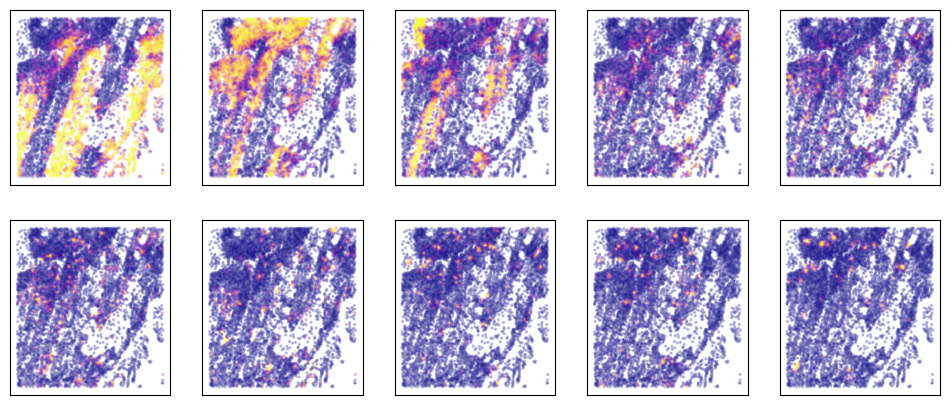

In [11]:
# Using weighting to smooth out the weights

# add cholesky to weights 
# create covariance matrix
phi = 3/np.percentile(dist,0.1)
sigma = 1
cov = np.exp(-phi*dist)
cov_sum = cov.sum(axis = 1)

w = cov / cov_sum[:,np.newaxis]
print(w.sum(axis = 1))

mat_s_w = w @ pos

max_val = np.percentile(mat_s_w, 99, 0)
min_val = np.percentile(mat_s_w, 1, 0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_w[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])